# Risk Sentiment - Currencies

## Imports

In [45]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [46]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data

### Riskfree Data

In [47]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_27191/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [48]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_27191/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [49]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


In [50]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


In [51]:
# --- Load Currency Prices ---
currency_data = pd.read_excel(
    f"{path}/FX Data.xlsx",
    sheet_name = 'RETURNS',
    index_col = 0,
    parse_dates = True
)
currency_data.index = pd.to_datetime(currency_data.index)
currency_data.index = currency_data.index + pd.offsets.MonthEnd(0)
currency_XR = currency_data

display(currency_XR)

,CH,EU,JP,UK,AU,EM
Date,,,,,,
1989-01-31,-0.062505,NaN,-0.044448,-0.028124,0.043550,NaN
1989-02-28,0.020885,NaN,0.025663,-0.002575,-0.095372,NaN
1989-03-31,-0.067754,NaN,-0.048472,-0.030821,0.027844,NaN
1989-04-30,-0.009532,NaN,-0.006180,0.004816,-0.025641,NaN
1989-05-31,-0.022300,NaN,-0.070709,-0.068691,-0.047106,NaN
...,...,...,...,...,...,...
2025-06-30,0.033185,0.036774,-0.003389,0.020141,0.022884,0.004021
2025-07-31,-0.027679,-0.033666,-0.048025,-0.038372,-0.024318,-0.009627
2025-08-31,0.010759,0.021636,0.021495,0.022178,0.017316,0.009796


In [52]:
currency_XR['US'] = 0.0
display(currency_XR)

,CH,EU,JP,UK,AU,EM,US
Date,,,,,,,
1989-01-31,-0.062505,NaN,-0.044448,-0.028124,0.043550,NaN,0.0
1989-02-28,0.020885,NaN,0.025663,-0.002575,-0.095372,NaN,0.0
1989-03-31,-0.067754,NaN,-0.048472,-0.030821,0.027844,NaN,0.0
1989-04-30,-0.009532,NaN,-0.006180,0.004816,-0.025641,NaN,0.0
1989-05-31,-0.022300,NaN,-0.070709,-0.068691,-0.047106,NaN,0.0
...,...,...,...,...,...,...,...
2025-06-30,0.033185,0.036774,-0.003389,0.020141,0.022884,0.004021,0.0
2025-07-31,-0.027679,-0.033666,-0.048025,-0.038372,-0.024318,-0.009627,0.0
2025-08-31,0.010759,0.021636,0.021495,0.022178,0.017316,0.009796,0.0


## Signal Generation

In [53]:
# --- Compute Risk Sentiment Signal ---
risk_sentiment_signal = equity_prices.pct_change(12).resample('ME').last()

display('Risk Sentiment Signal:')
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


In [54]:
# --- Composite Signal Construction ---
# Logic: For Currencies, we want increasing Risk Sentiment (+)
risk_sentiment_signal = risk_sentiment_signal

display("Risk Sentiment Signal:")
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


## Portfolio Construction

In [55]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=risk_sentiment_signal,
    returns= currency_XR,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,AU,CH,JP,UK,EM,EU
2001-09-30,-0.477281,0.795469,0.477281,-0.795469,0.159094,NaN,-0.159094
2001-10-31,-0.154733,0.773666,0.464199,-0.773666,0.154733,NaN,-0.464199
2001-11-30,-0.158114,0.790571,0.474342,-0.790571,0.158114,NaN,-0.474342
2001-12-31,0.464254,0.773757,-0.154751,-0.773757,0.154751,NaN,-0.464254
2002-01-31,0.456338,0.760564,-0.152113,-0.760564,0.152113,NaN,-0.456338
...,...,...,...,...,...,...,...
2025-05-31,-1.031143,-1.546714,1.546714,0.000000,-0.515571,1.031143,0.515571
2025-06-30,-1.010982,-1.516474,1.010982,0.505491,-0.505491,1.516474,0.000000
2025-07-31,-1.009660,-1.514490,-0.504830,0.504830,0.000000,1.514490,1.009660
2025-08-31,0.508965,-1.526895,-1.017930,-0.508965,1.017930,0.000000,1.526895


In [56]:
weights = pmp.append_final_zero_row(weights)

## Backtest

In [57]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = currency_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroRS_fx.csv')

# Performance Statistics

In [58]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,7.3793,3.0760
Arithm Avg Xs Return,5.7716,1.4682
Std Xs Returns,9.6844,10.3463
Sharpe Arithmetic,0.5960,0.1419
Geom Avg Total Return,7.1311,2.5722
Geom Avg Xs Return,5.5128,0.9540
Sharpe Geometric,0.5692,0.0922
Min Xs Return,-10.2114,-8.9057
Max Xs Return,8.6715,10.9811
Skewness,-0.4922,0.0624


## Plots

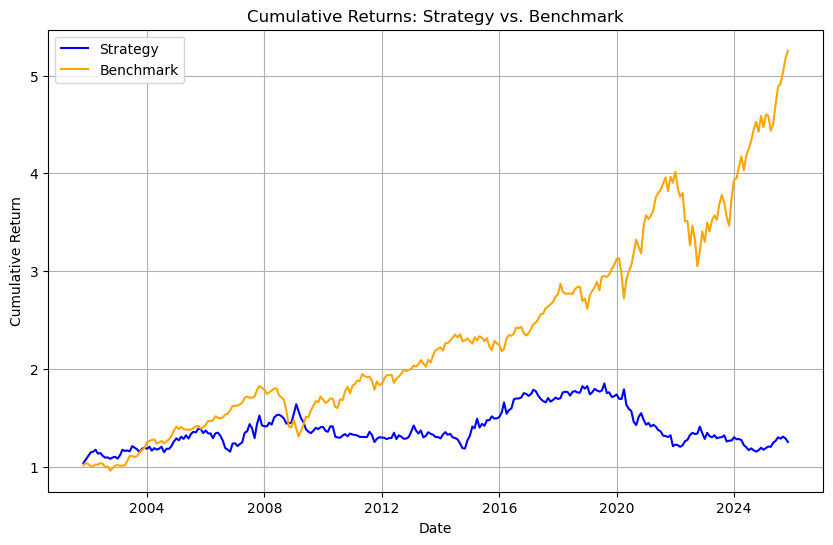

In [59]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()